In [1]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from astropy.io import fits

%matplotlib inline

In [2]:
# read image
with fits.open("image.fits") as hdul:
    data = hdul[0].data

ESO-LOG 00:00:00> DATE         = '1992-10-26'  / Mon Oct 26, 1992                [astropy.io.fits.card]
ESO-LOG 03:04:08>-START EXPO EMMI RED          / Start exp. on EMMI Red CC       [astropy.io.fits.card]
ESO-LOG 03:04:09> EXPO EMMI RED NO = 24887     / Exp. num. on EMMI Red CCD       [astropy.io.fits.card]
ESO-LOG 03:10:52>-STOP EXPO EMMI RED           / Stop exp. on EMMI Red CCD       [astropy.io.fits.card]


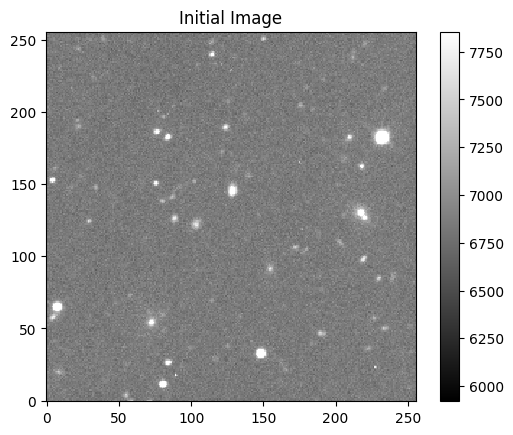

In [3]:
# show the image
m,s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest',cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.title("Initial Image")
plt.savefig('initial_image.png')
plt.show()

In [4]:
# measure a spatially varying background on the image
bkg = sep.Background(data)

In [5]:
# "global mean and noise of the image background
print(bkg.globalback)
print(bkg.globalrms)

6852.04931640625
65.46174621582031


In [6]:
# evaluate background as 2-D array, same size as original image
bkg_image = bkg.back()

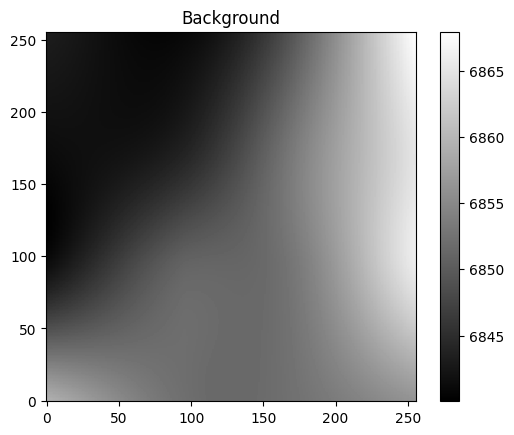

In [7]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.title("Background")
plt.savefig('background_image.png')
plt.show()

In [8]:
# evaluate the background noise as 2-D array, same size as original
bkg_rms = bkg.rms()

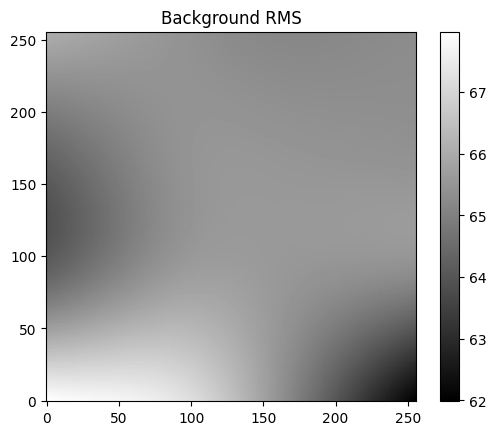

In [9]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.title("Background RMS")
plt.savefig('background_noise_image.png')
plt.show()

In [10]:
# subtract the background
data_sub = data - bkg

## Object Detection

In [11]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [12]:
# how many objects were detected 
len(objects)

68

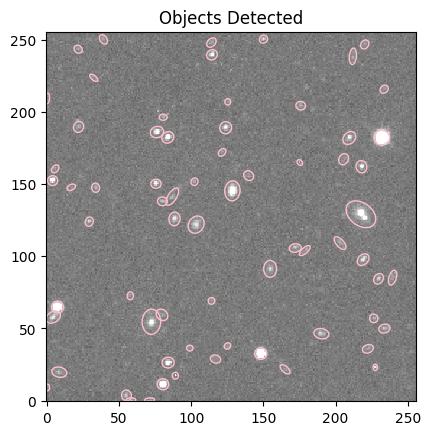

In [13]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object 
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width = 6*objects['a'][i],
                height = 6*objects['b'][i],
                angle = objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('pink')
    ax.add_artist(e)
plt.title("Objects Detected")
plt.savefig('objects_detected_image.png')
plt.show()

In [14]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

## Aperature Photometry

In [15]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [16]:
# show the first 10 objects results:
for i in range(10):
    print("object{:d}: flux={:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object0: flux=2249.159297 +/- 291.027802
object1: flux=3092.220430 +/- 291.592204
object2: flux=5949.868379 +/- 356.562003
object3: flux=1851.426582 +/- 295.028816
object4: flux=72736.386914 +/- 440.172206
object5: flux=3860.756152 +/- 352.163162
object6: flux=6418.913789 +/- 357.458973
object7: flux=2210.707656 +/- 350.791223
object8: flux=2741.607227 +/- 352.277746
object9: flux=20916.875566 +/- 376.966138


In [17]:
# get hubble image
with fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits") as hdul:
    data_udf = hdul[0].data
    data_udf = data_udf.byteswap().newbyteorder()

In [18]:
bkg_udf = sep.Background(data_udf)
data_sub_udf = data_udf - bkg_udf

In [19]:
objects_udf = sep.extract(data_sub_udf, 1.5, err=bkg_udf.globalrms)
print(f"Number of sources detected: {len(objects_udf)}")

Number of sources detected: 8640


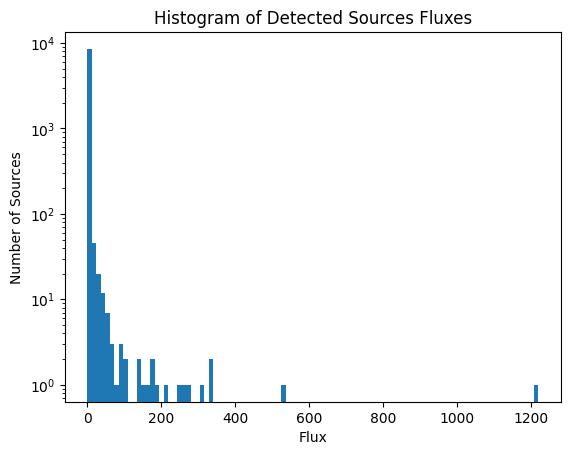

In [20]:
# get the fluxes 
fluxes = [obj['flux'] for obj in objects_udf]

# plot the histogram
plt.hist(fluxes, bins=100, log=True)
plt.title("Histogram of Detected Sources Fluxes")
plt.xlabel("Flux")
plt.ylabel("Number of Sources")
plt.savefig('flux_histogram.png')
plt.show()

In [21]:
# find the mean, median, standard deviation, and largest outlier flux

mean_flux = np.mean(fluxes)
median_flux = np.median(fluxes)
std_flux = np.std(fluxes)
largest_outlier_flux = np.max(fluxes)
largest_outlier_index = np.argmax(fluxes)
largest_outlier_position = (objects_udf[largest_outlier_index]['x'],objects_udf[largest_outlier_index]['y'])
outlier_std_devs_from_mean = (largest_outlier_flux - mean_flux) / std_flux

In [22]:
print(f"Mean flux: {mean_flux}")
print(f"Median flux: {median_flux}")
print(f"Standard deviation of fluxes: {std_flux}")
print(f"Largest outlier flux: {largest_outlier_flux}, at position {largest_outlier_position}")
print(f"The largest outlier is {outlier_std_devs_from_mean} standard deviations from mean")

Mean flux: 1.1726778032743217
Median flux: 0.034888697788119316
Standard deviation of fluxes: 17.547420912246842
Largest outlier flux: 1218.3980712890625, at position (1914.2549094883857, 1134.3164850742164)
The largest outlier is 69.36776632720151 standard deviations from mean


In [23]:
with fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits') as hdul:
    f125w_data = hdul[0].data.byteswap().newbyteorder()
f125w_norm = f125w_data/np.max(f125w_data)

with fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits') as hdul:
    f160w_data = hdul[0].data.byteswap().newbyteorder()
f160w_norm = f160w_data/np.max(f160w_data)

with fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits') as hdul:
    f105w_data = hdul[0].data.byteswap().newbyteorder()
f105w_norm = f105w_data/np.max(f105w_data)

In [24]:
# define file names 
fdata_F125W = 'hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits'
fdata_F160W = 'hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits'
fdata_F105W = 'hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits'

#read in data
hdu_2 = fits.open(fdata_F125W)
hdu_3 = fits.open(fdata_F160W)
hdu_4 = fits.open(fdata_F105W)

#get the image data
data_2 = hdu_2[0].data
data_3 = hdu_3[0].data
data_4 = hdu_4[0].data

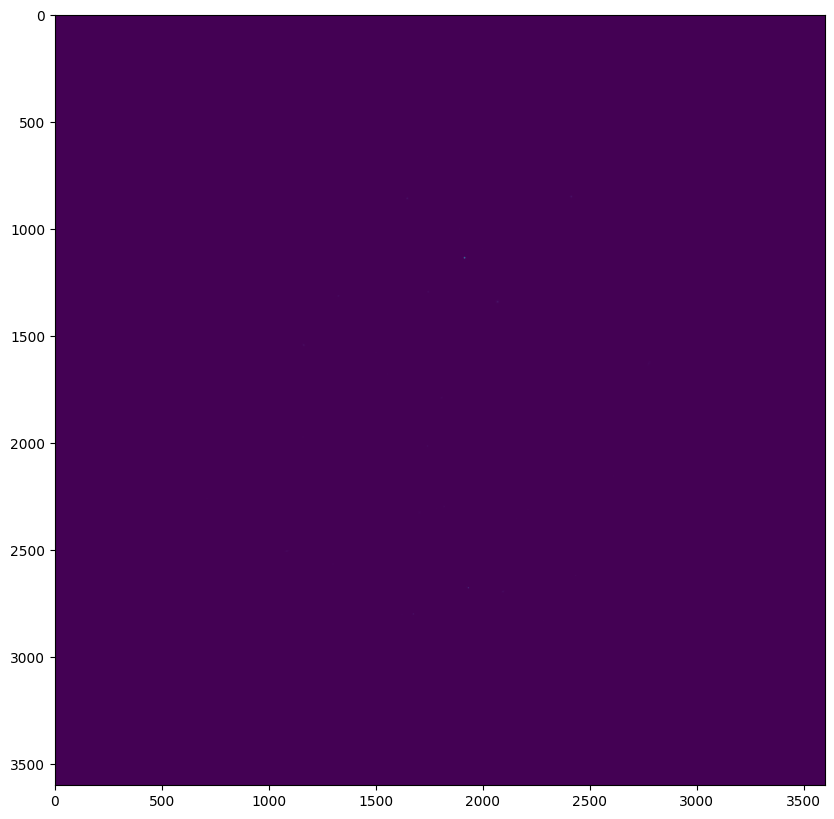

In [25]:
f = plt.figure(figsize=[10,10])
plt.imshow(data_2)

In [47]:
def rescale_image(data):
    #copy the data 
    pdata_tmp = data.copy()
    #compute the mean value over all data
    m = np.nanmean(pdata_tmp)

    vpmin = 0.5*m
    vpmax = 100*m
    pdata_tmp[pdata_tmp<vpmin] = vpmin
    pdata_tmp[pdata_tmp>vpmax] = vpmax
    pdata_tmp = np.nan_to_num(pdata_tmp, nan=vpmin)

    #apply logscale
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp

In [48]:
# use these rescaled images
data_2_res = rescale_image(data_2)
data_3_res = rescale_image(data_3)
data_4_res = rescale_image(data_4)

In [55]:
data_all = np.zeros((data_2.shape[0],data_2.shape[1],3))

data_all[:,:,0] = data_2
data_all[:,:,1] = data_3
data_all[:,:,2] = data_4

In [60]:
def remap(data):
   #copy our data
    pdata_tmp = data.copy()

    dmin = pdata_tmp.min()
    dmax = pdata_tmp.max()
    return (pdata_tmp - dmin)/(dmax-dmin)

In [57]:
rgb_image = np.zeros((data_2.shape[0],data_2.shape[1],3))

rgb_image = remap(data_all)

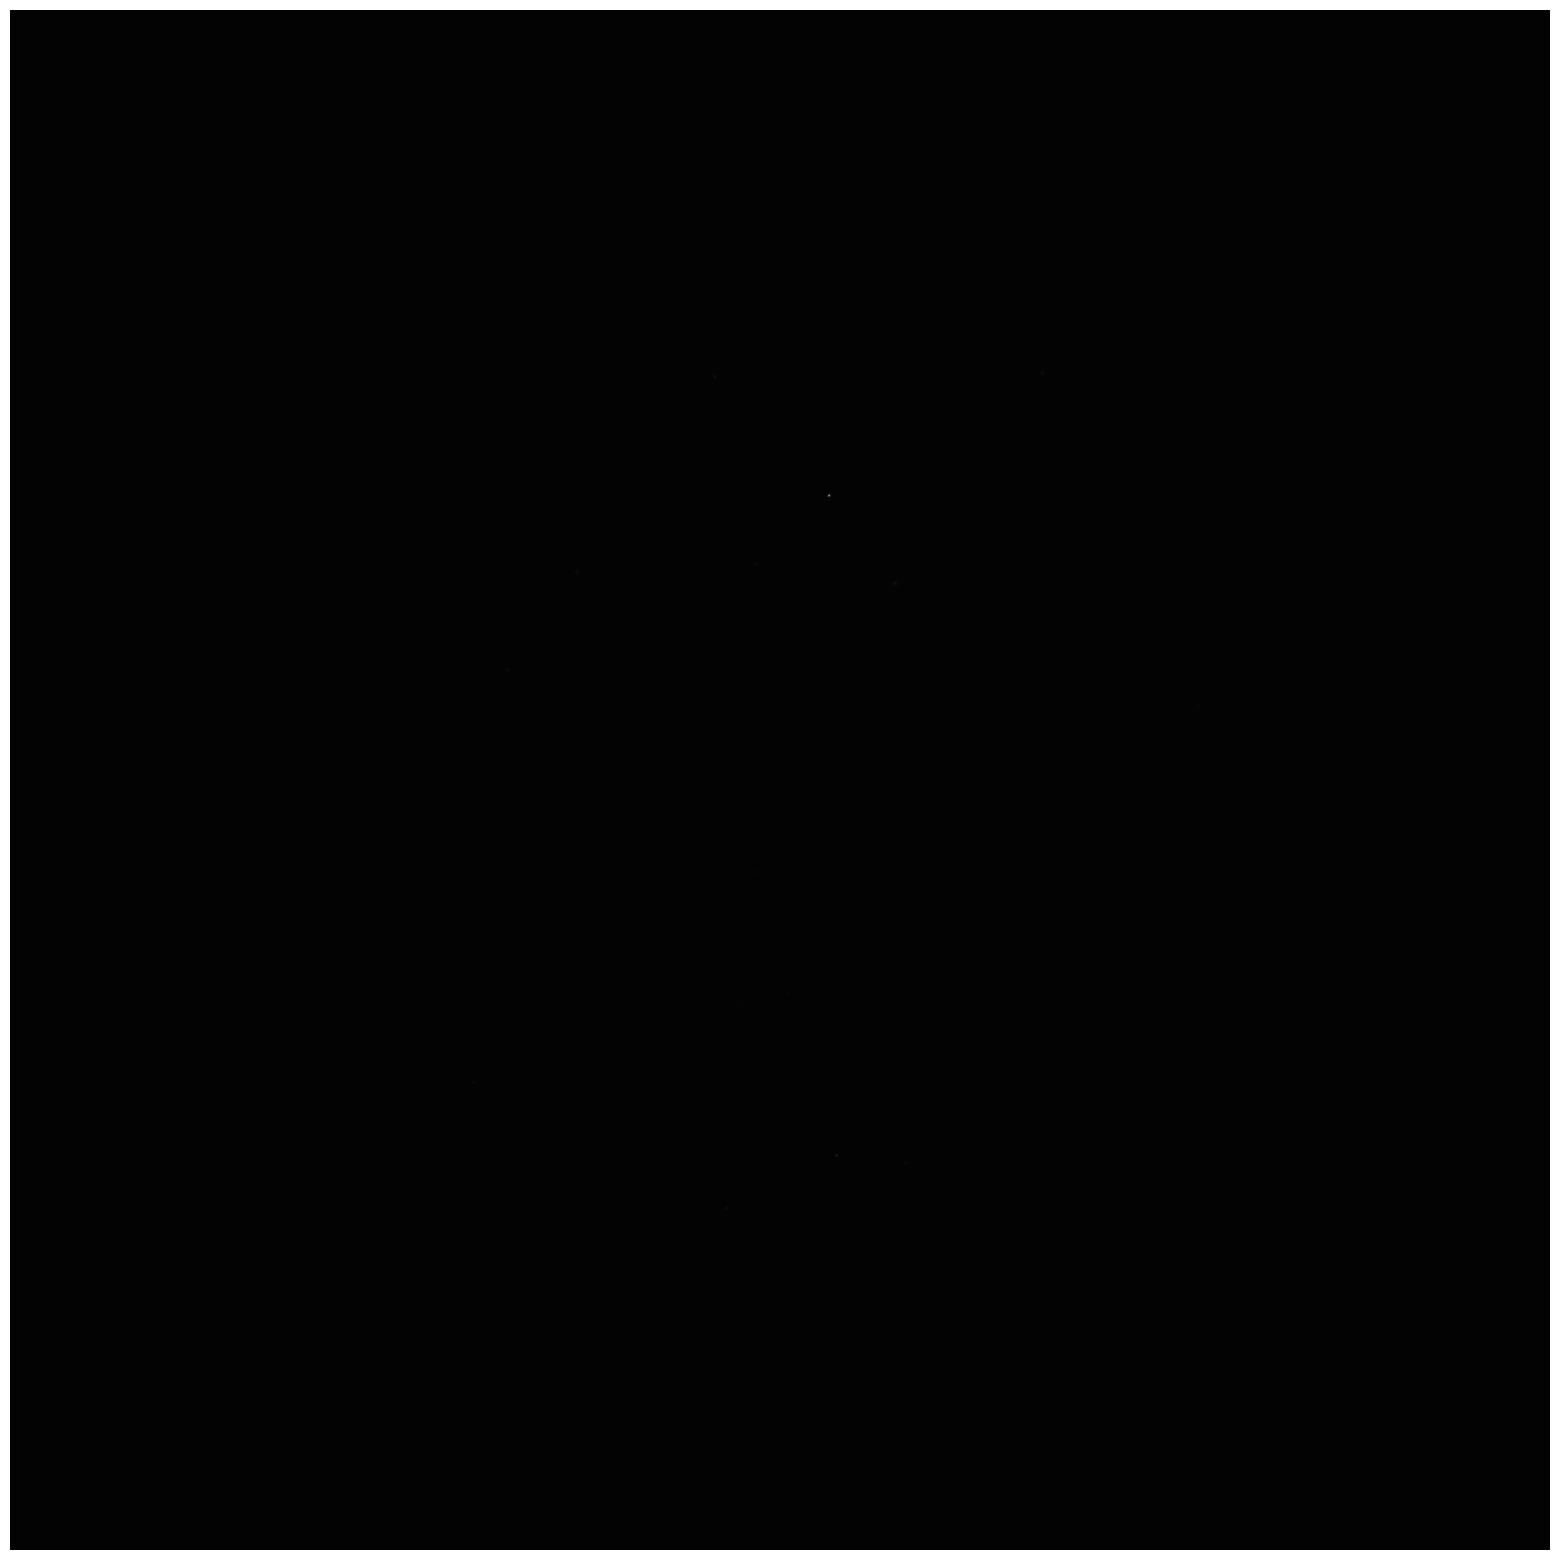

In [59]:
f,ax = plt.subplots(1,1,figsize=(20,20))
ax.axis('off')
ax.imshow(rgb_image)
plt.savefig('3_color_false_image.png',bbox_inches='tight',pad_inches=0,dpi=600)
plt.show()